In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [5, 5]
from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from IPython.display import display, Math

C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
data = np.load(r"C:\Users\Admin\reps\astrostatistics_bicocca_2024\solutions\transient.npy")

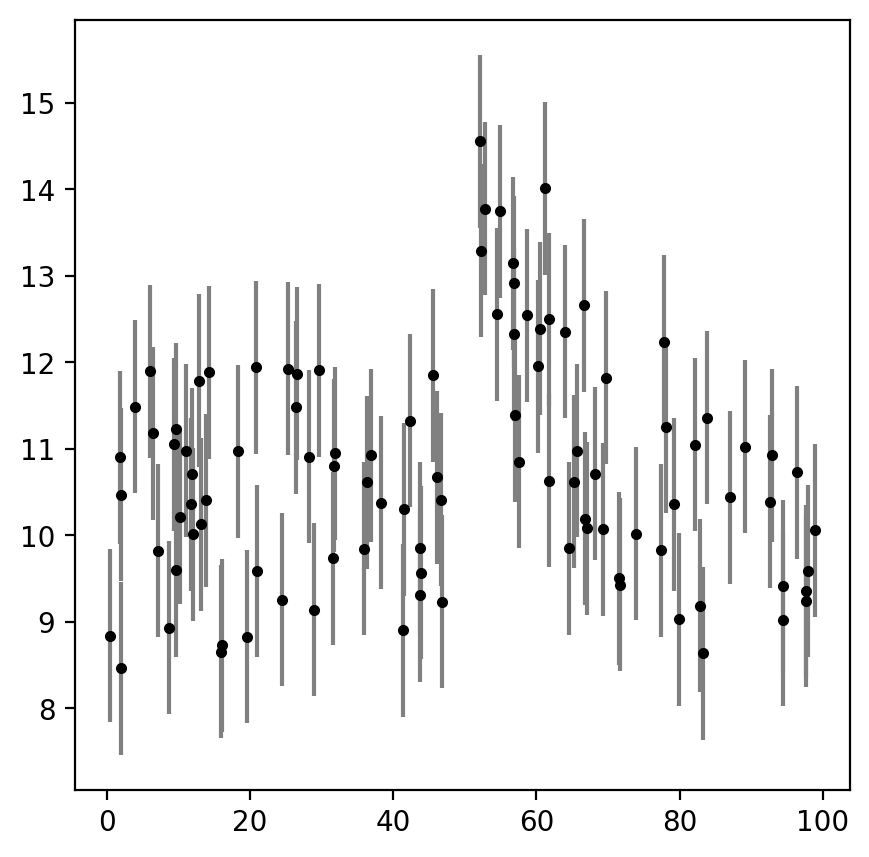

In [3]:
time = data[:,0]
flux = data[:,1]
uncertanties = data[:,2]
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
plt.show()

In [4]:
def burst_model(time, b, A, a, t_0):
    
    return np.where(time<t_0, b, b + A*np.exp(-a*(time-t_0)))

def gaussian_model(time, b, A, a, t_0):
         
    return b+A*np.exp(-(((time-t_0)/a)**2 ) / 2)

In [5]:
def log_likelihood(theta, time, flux, uncertanties, model):
    
    b, A, a, t_0 = theta
    
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))
 
# Define our uniform prior.
def ptform(u, model):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our prior for each variable."""
    
    b = uniform.ppf(u[0], 0, 50) 
    A = uniform.ppf(u[1], 0, 50)
    t_0 = uniform.ppf(u[3], 0, 100)
    
    if model == burst_model:
        a = np.exp(uniform.ppf(u[2], -5, 5))
    
    elif model == gaussian_model:
        a = uniform.ppf(u[2], 0, 15)
    
    return [b, A, a, t_0]

In [6]:
# Define the dimensionality of our problem.
ndim = 4

# Burst Model

In [8]:
popt, pcov = optimize.curve_fit(burst_model, time, flux, p0 = [10.0, 5.0, 1, 50.0]) #estimation of parameters using non-linear least squares.

In [9]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, uncertanties, burst_model], ptform_args=[burst_model], nlive=300)
sampler.run_nested()
sresults = sampler.results

4606it [01:33, 49.07it/s, +300 | bound: 123 | nc: 1 | ncall: 66079 | eff(%):  7.458 | loglstar:   -inf < -48.761 <    inf | logz: -62.833 +/-  0.209 | dlogz:  0.001 >  0.309]


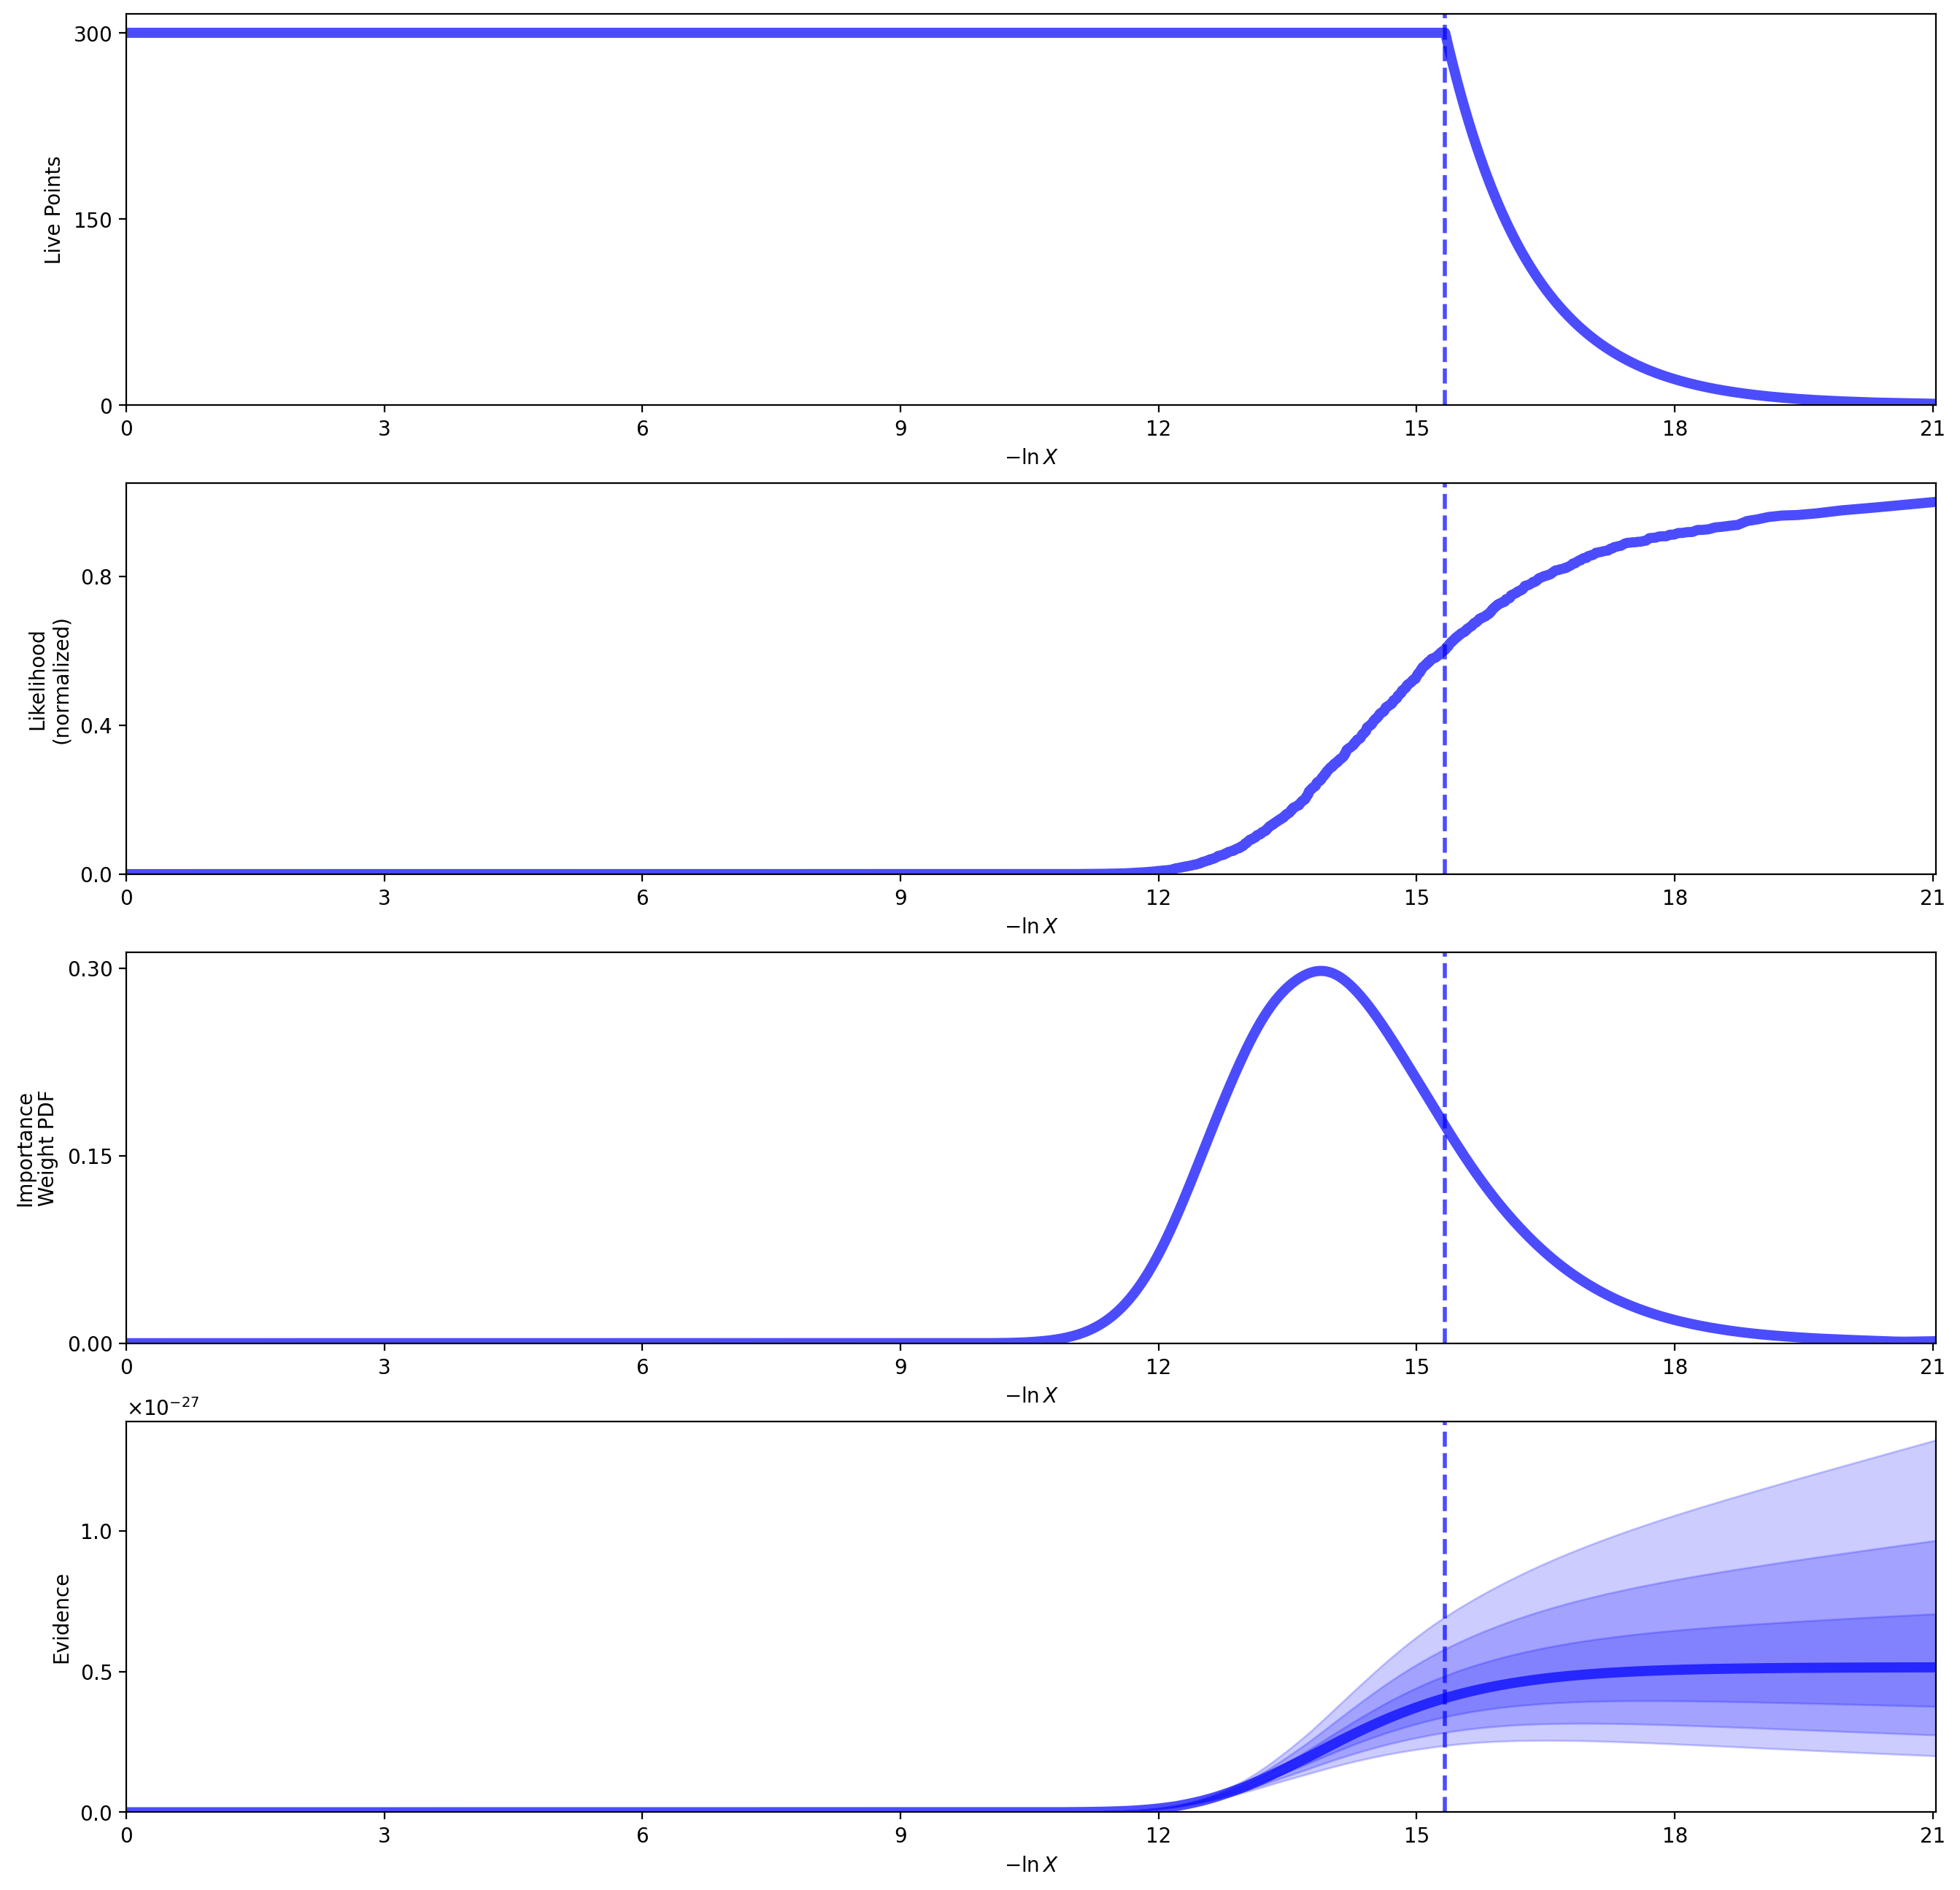

In [10]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

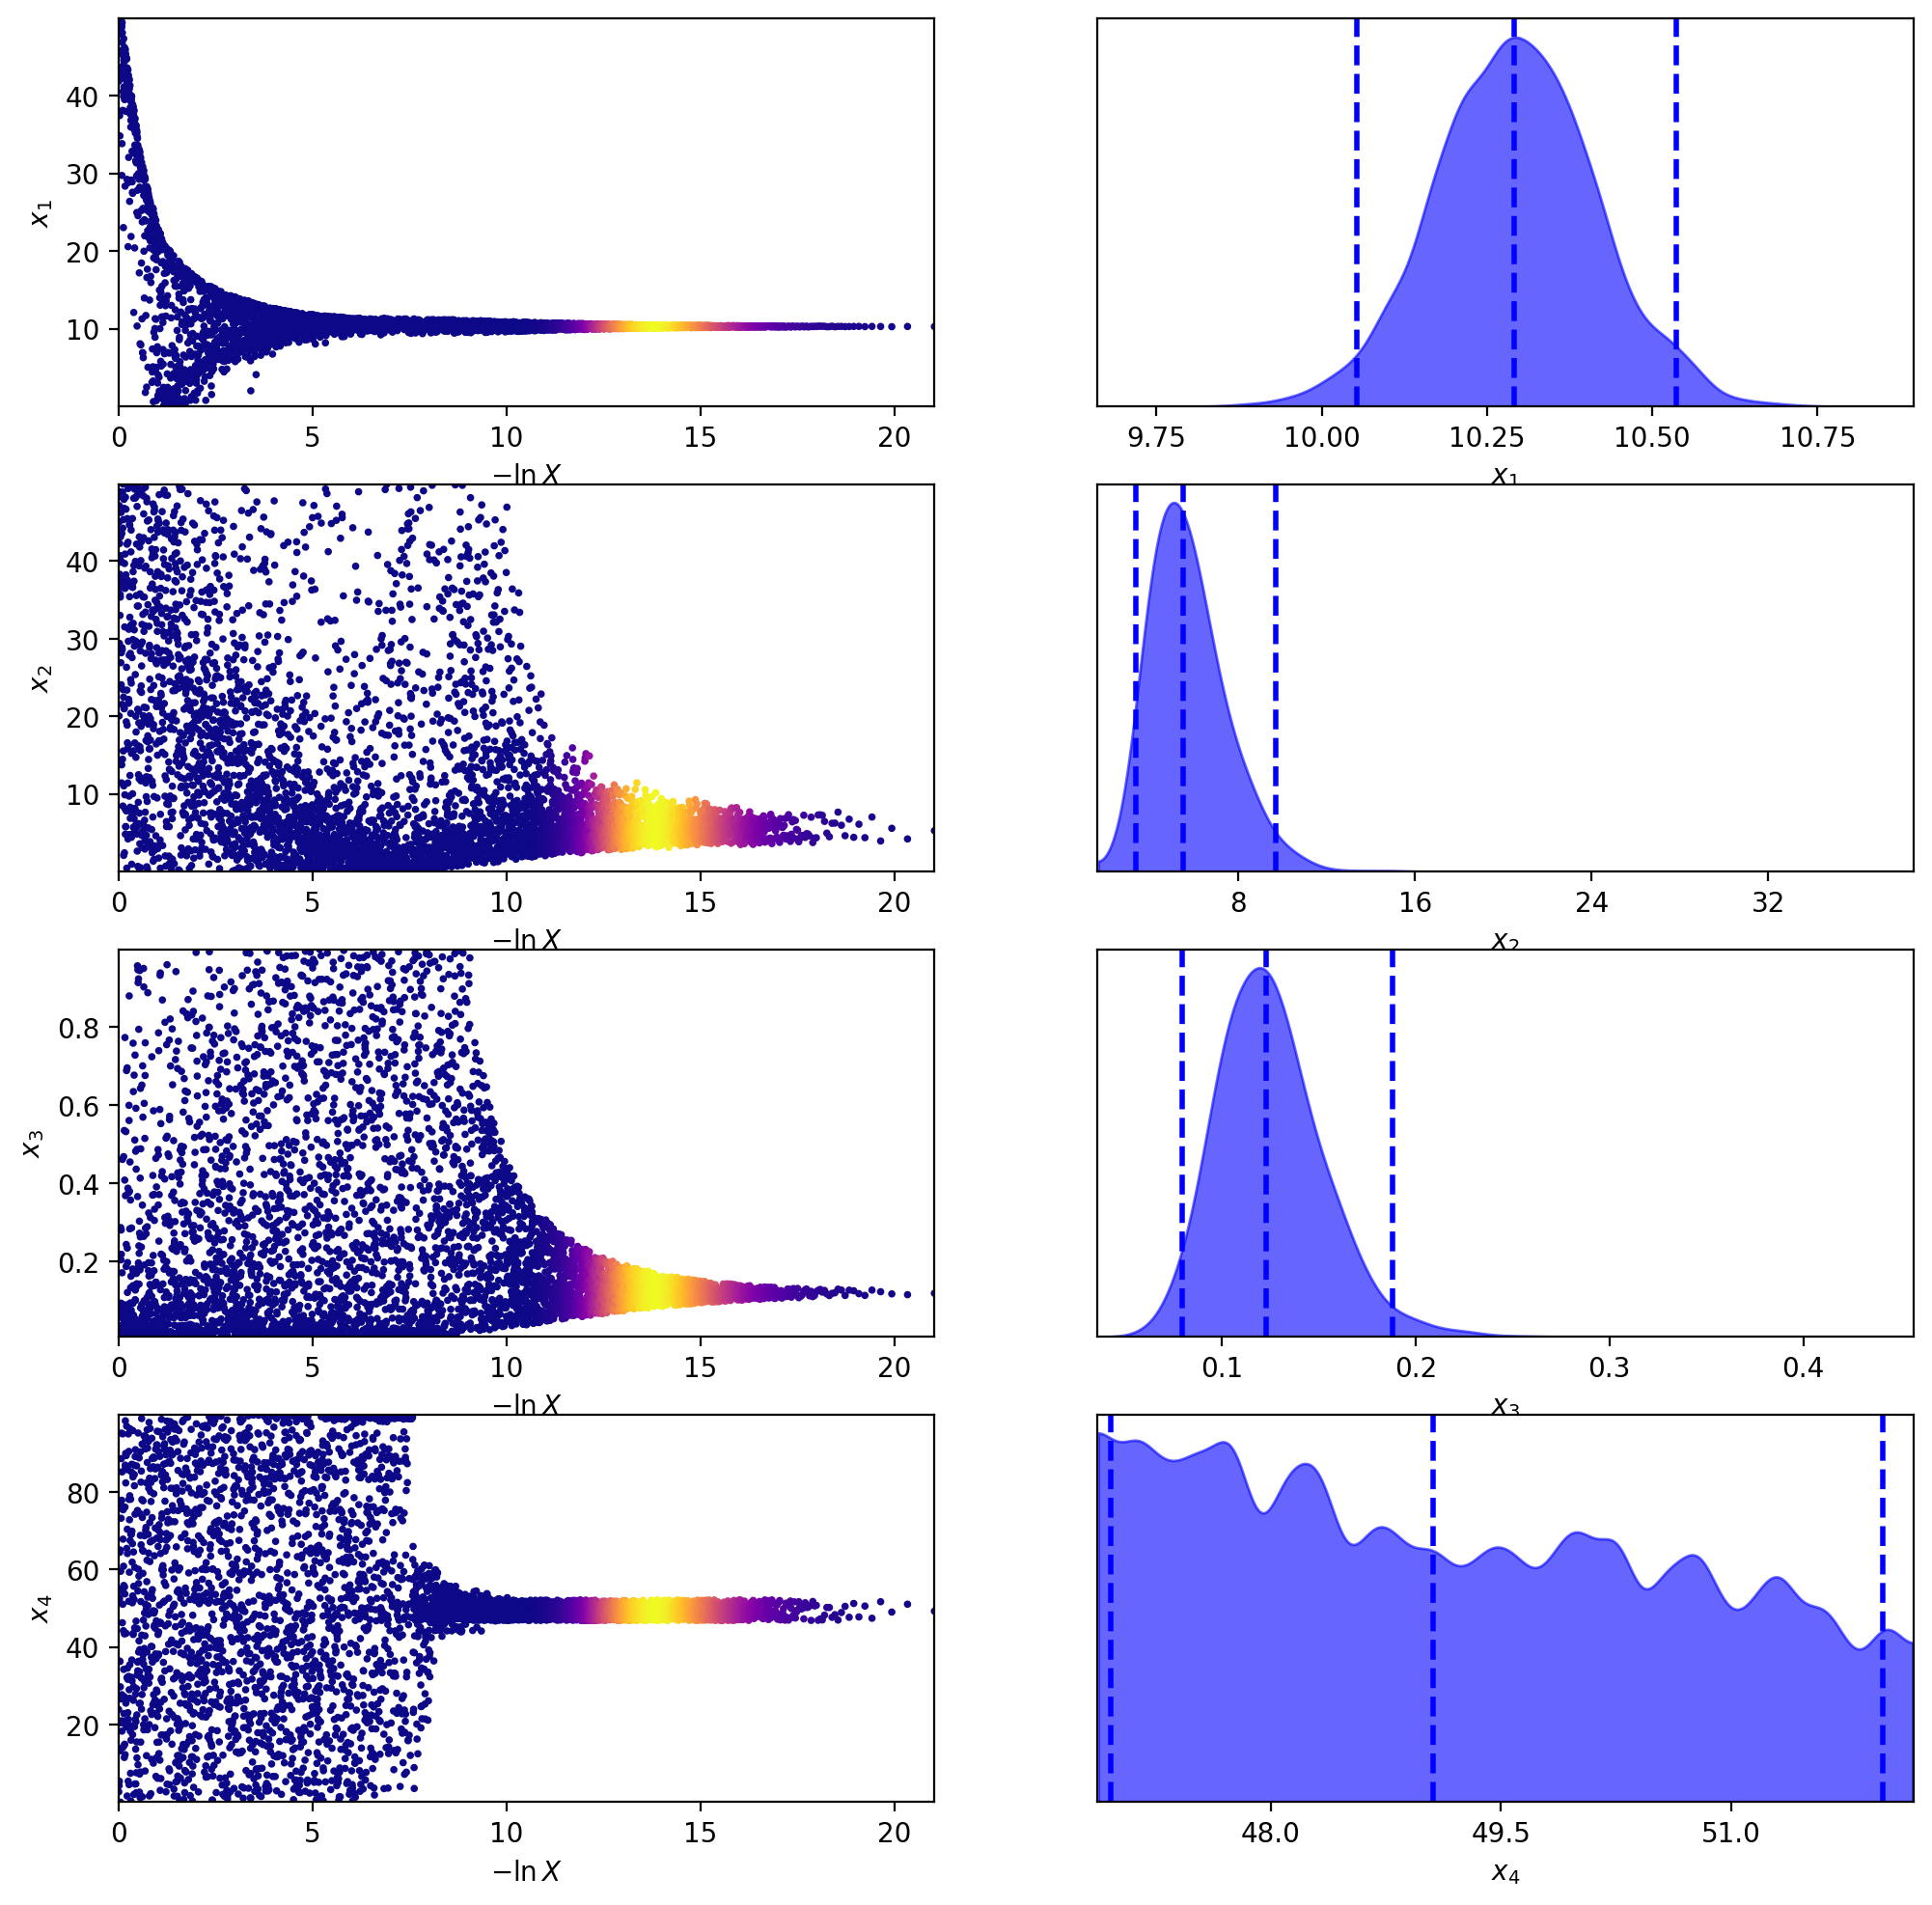

In [11]:
tfig, taxes = dyplot.traceplot(sresults)

In [12]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 5.149500018072637e-28
90% parameter credible regions are:
 [[10.139973870133845, 10.445205925151503], [3.8992345687060097, 8.058897346920075], [0.09358676243637766, 0.16061771244389195], [47.2593494442291, 51.39245613842449]]

Mean and covariance of parameters are: [10.29236076  5.74542466  0.12528501 49.2000999 ]
[[ 1.48157650e-02  1.92041071e-02  1.34254493e-03 -8.60486768e-03]
 [ 1.92041071e-02  2.81896484e+00  2.70149610e-02 -1.75484239e+00]
 [ 1.34254493e-03  2.70149610e-02  7.53408391e-04 -2.58421777e-03]
 [-8.60486768e-03 -1.75484239e+00 -2.58421777e-03  2.29270890e+00]]


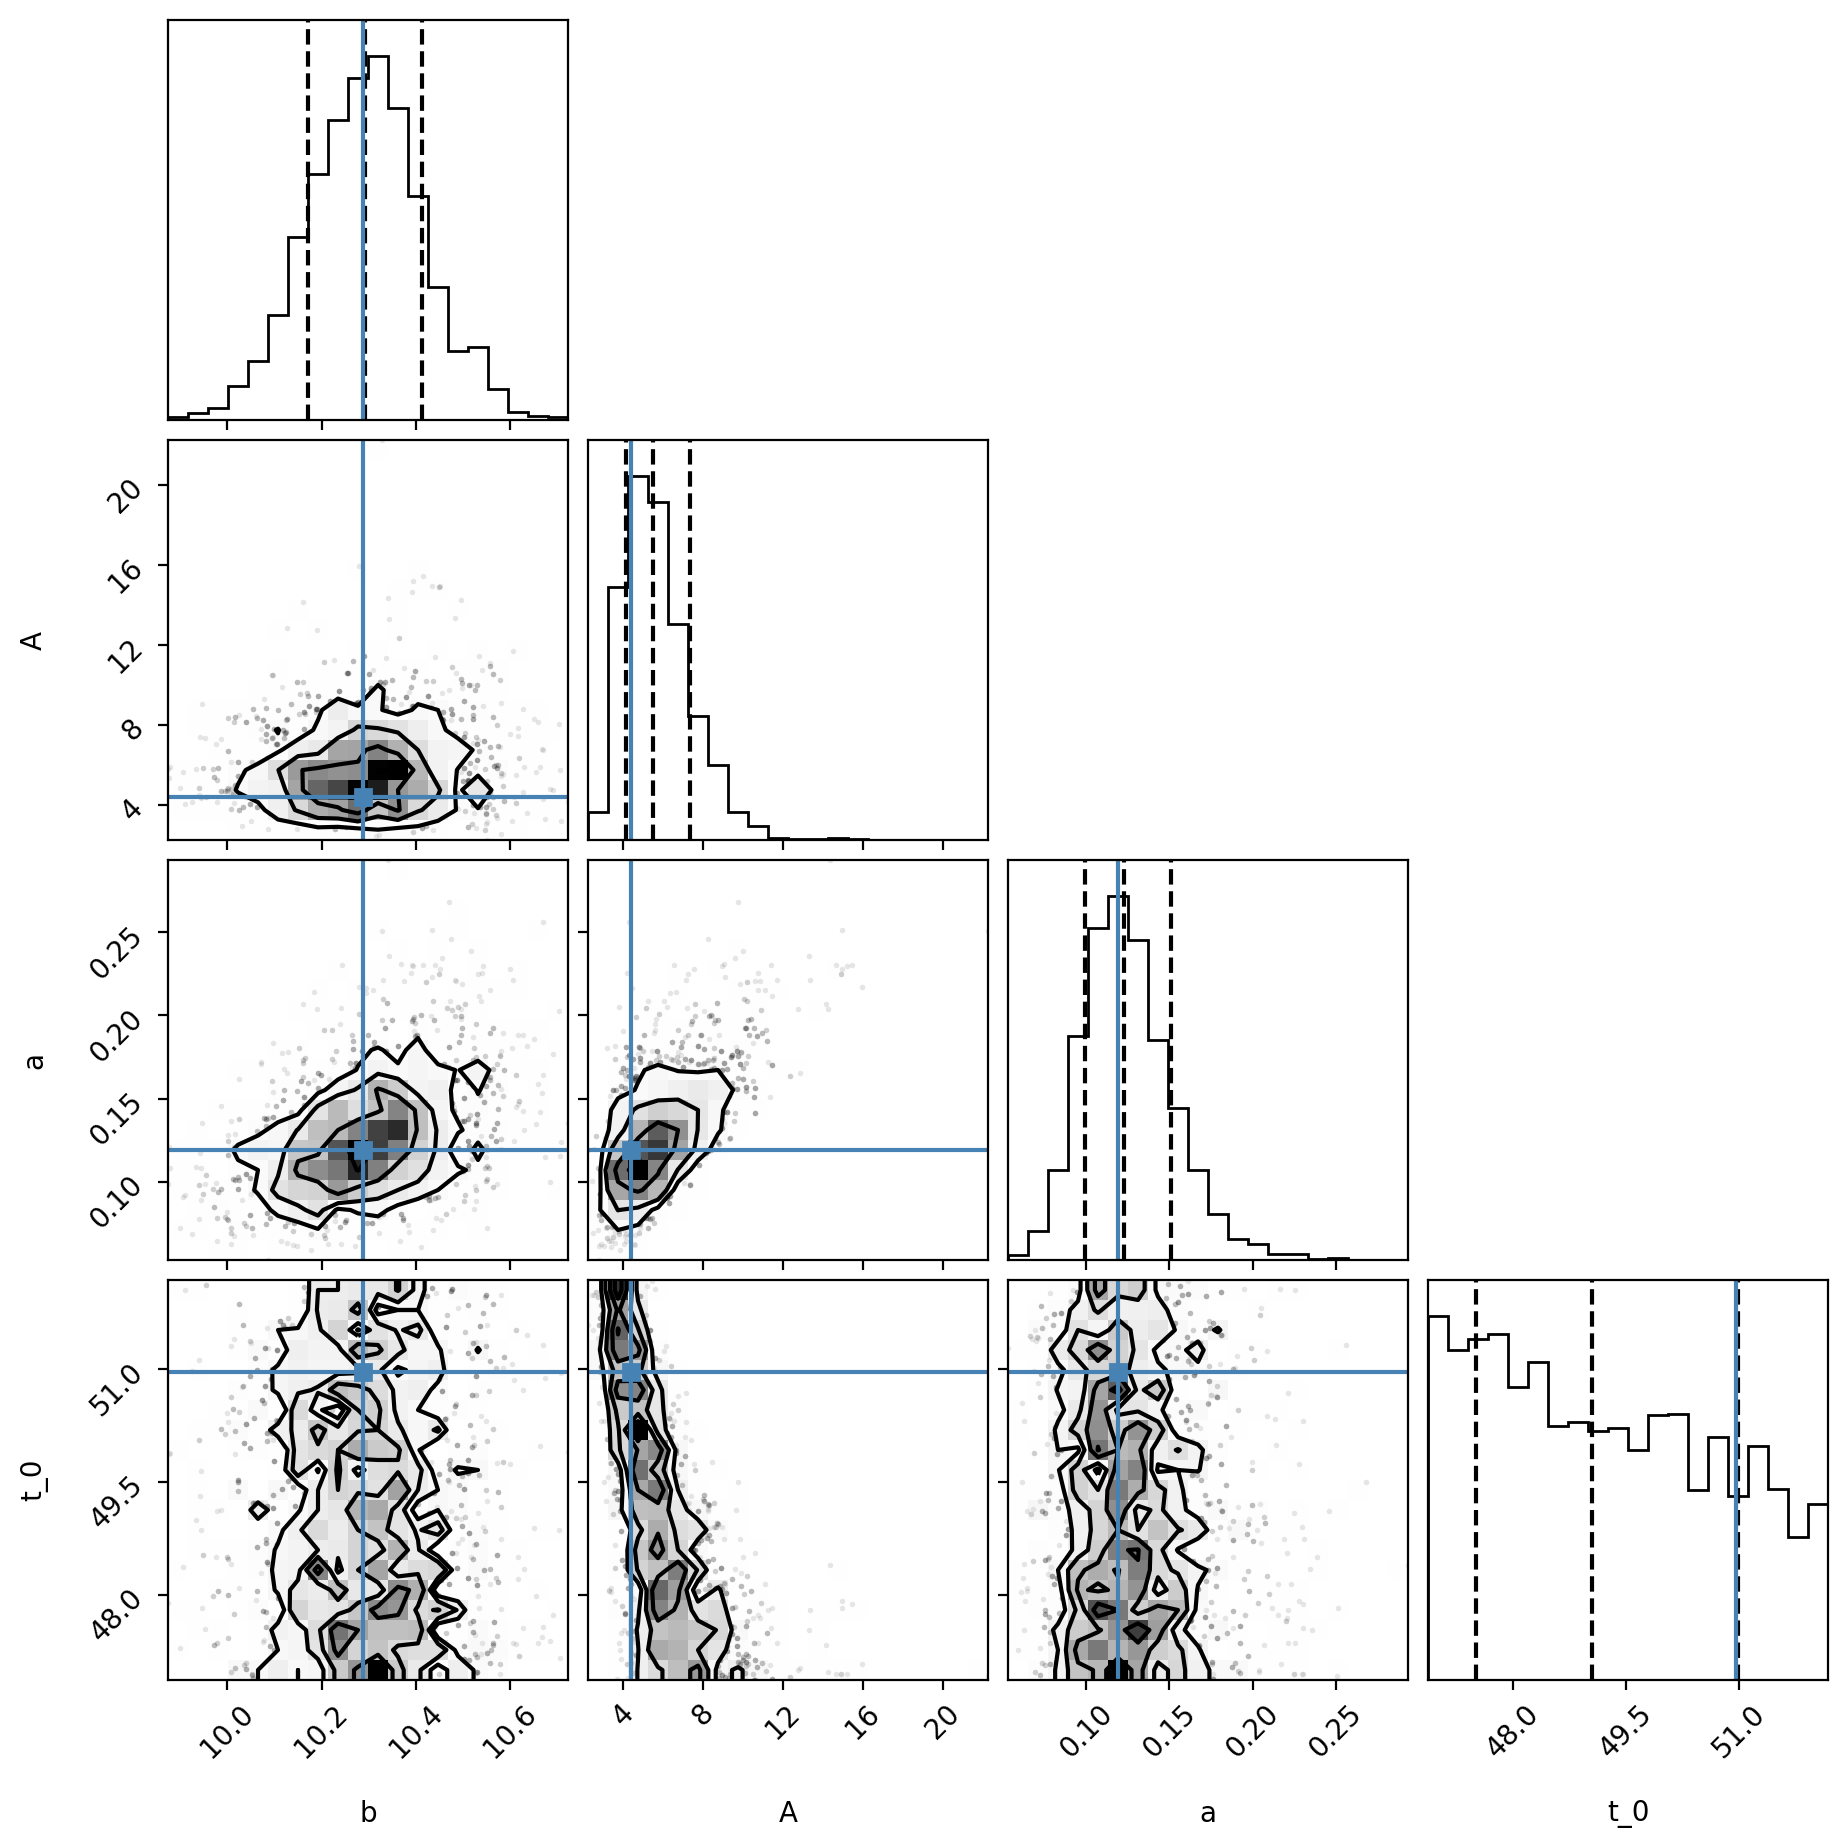

In [13]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ["b", "A", "a", "t_0"]
corner.corner(samples_equal, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [0.16, 0.5, 0.84]);

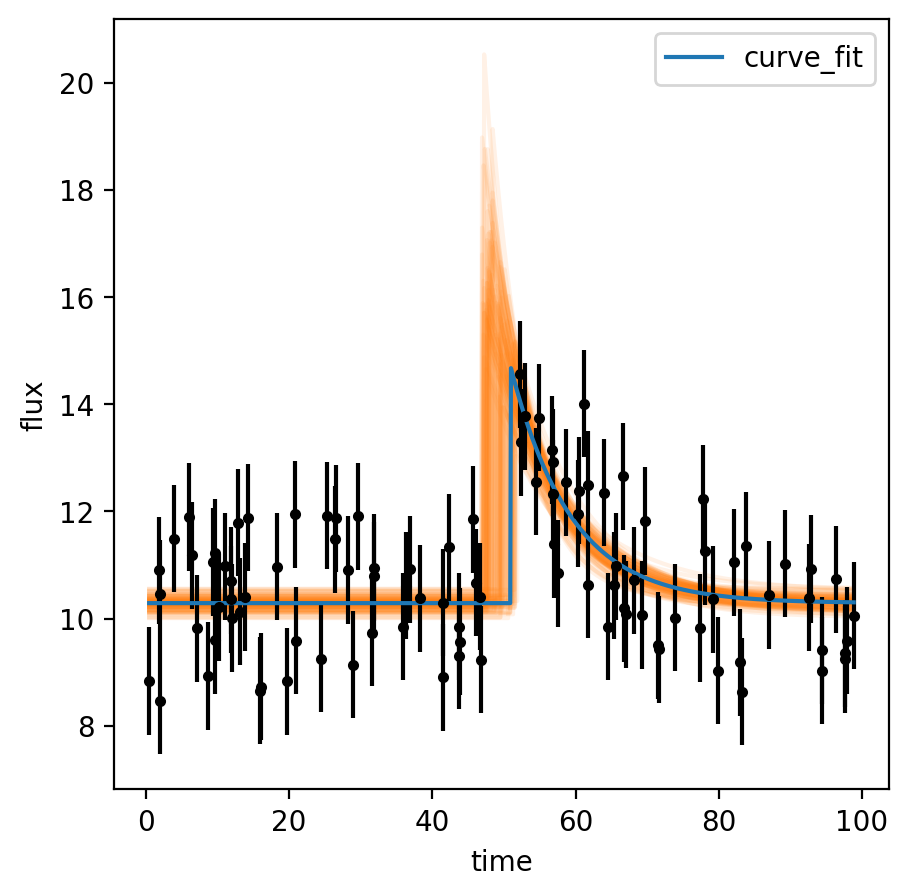

In [14]:
inds = np.random.randint(len(samples_equal), size=100)
x_fit = np.linspace(min(time), max(time), 1000)

for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_fit, burst_model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, burst_model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="curve_fit")
plt.legend()

plt.xlabel("time")
plt.ylabel("flux");

In [15]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
sresults.summary()

Summary
nlive: 300
niter: 4606
ncall: 65779
eff(%):  7.458
logz: -62.833 +/-  0.315


# Gaussian Model

In [17]:
popt, pcov = optimize.curve_fit(gaussian_model, time, flux, p0 = [10.0, 5.0, 1, 50.0]) #estimation of parameters using non-linear least squares.

In [18]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, uncertanties, gaussian_model], ptform_args=[gaussian_model], nlive=300)
sampler.run_nested()
sresults_g = sampler.results

4863it [01:17, 62.76it/s, +300 | bound: 105 | nc: 1 | ncall: 57800 | eff(%):  8.979 | loglstar:   -inf < -52.429 <    inf | logz: -67.393 +/-  0.216 | dlogz:  0.001 >  0.309] 


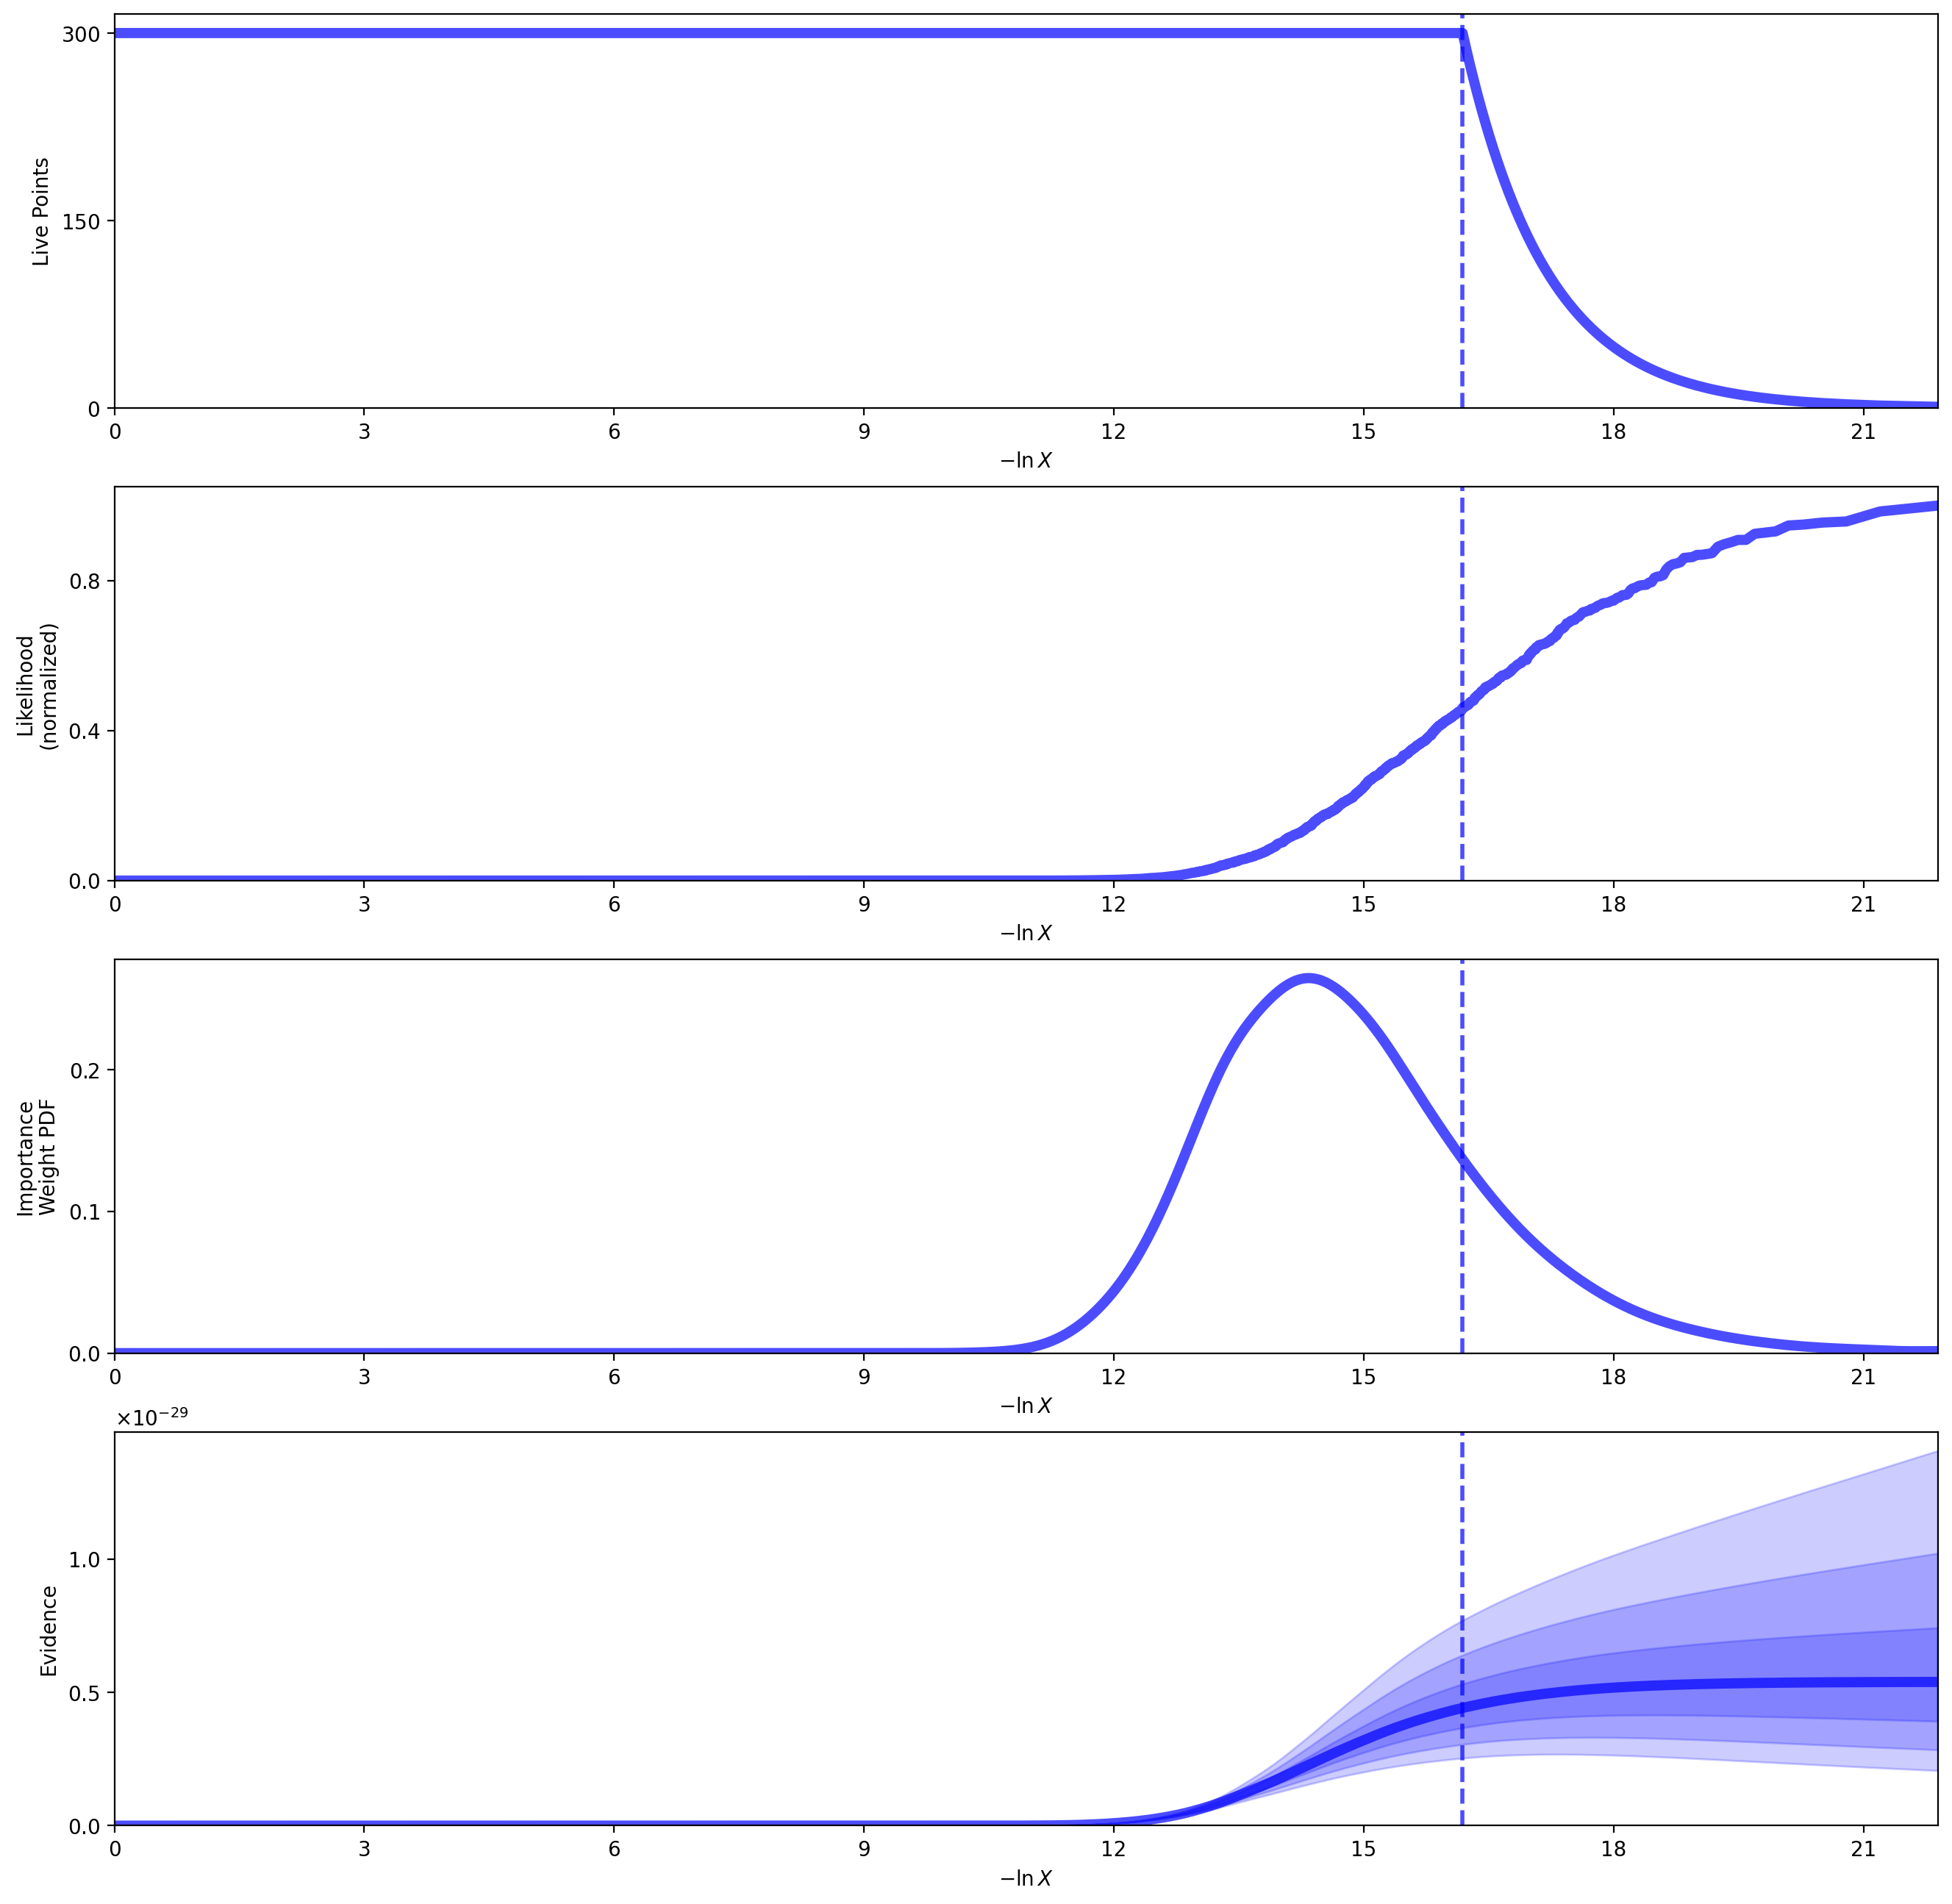

In [19]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_g)

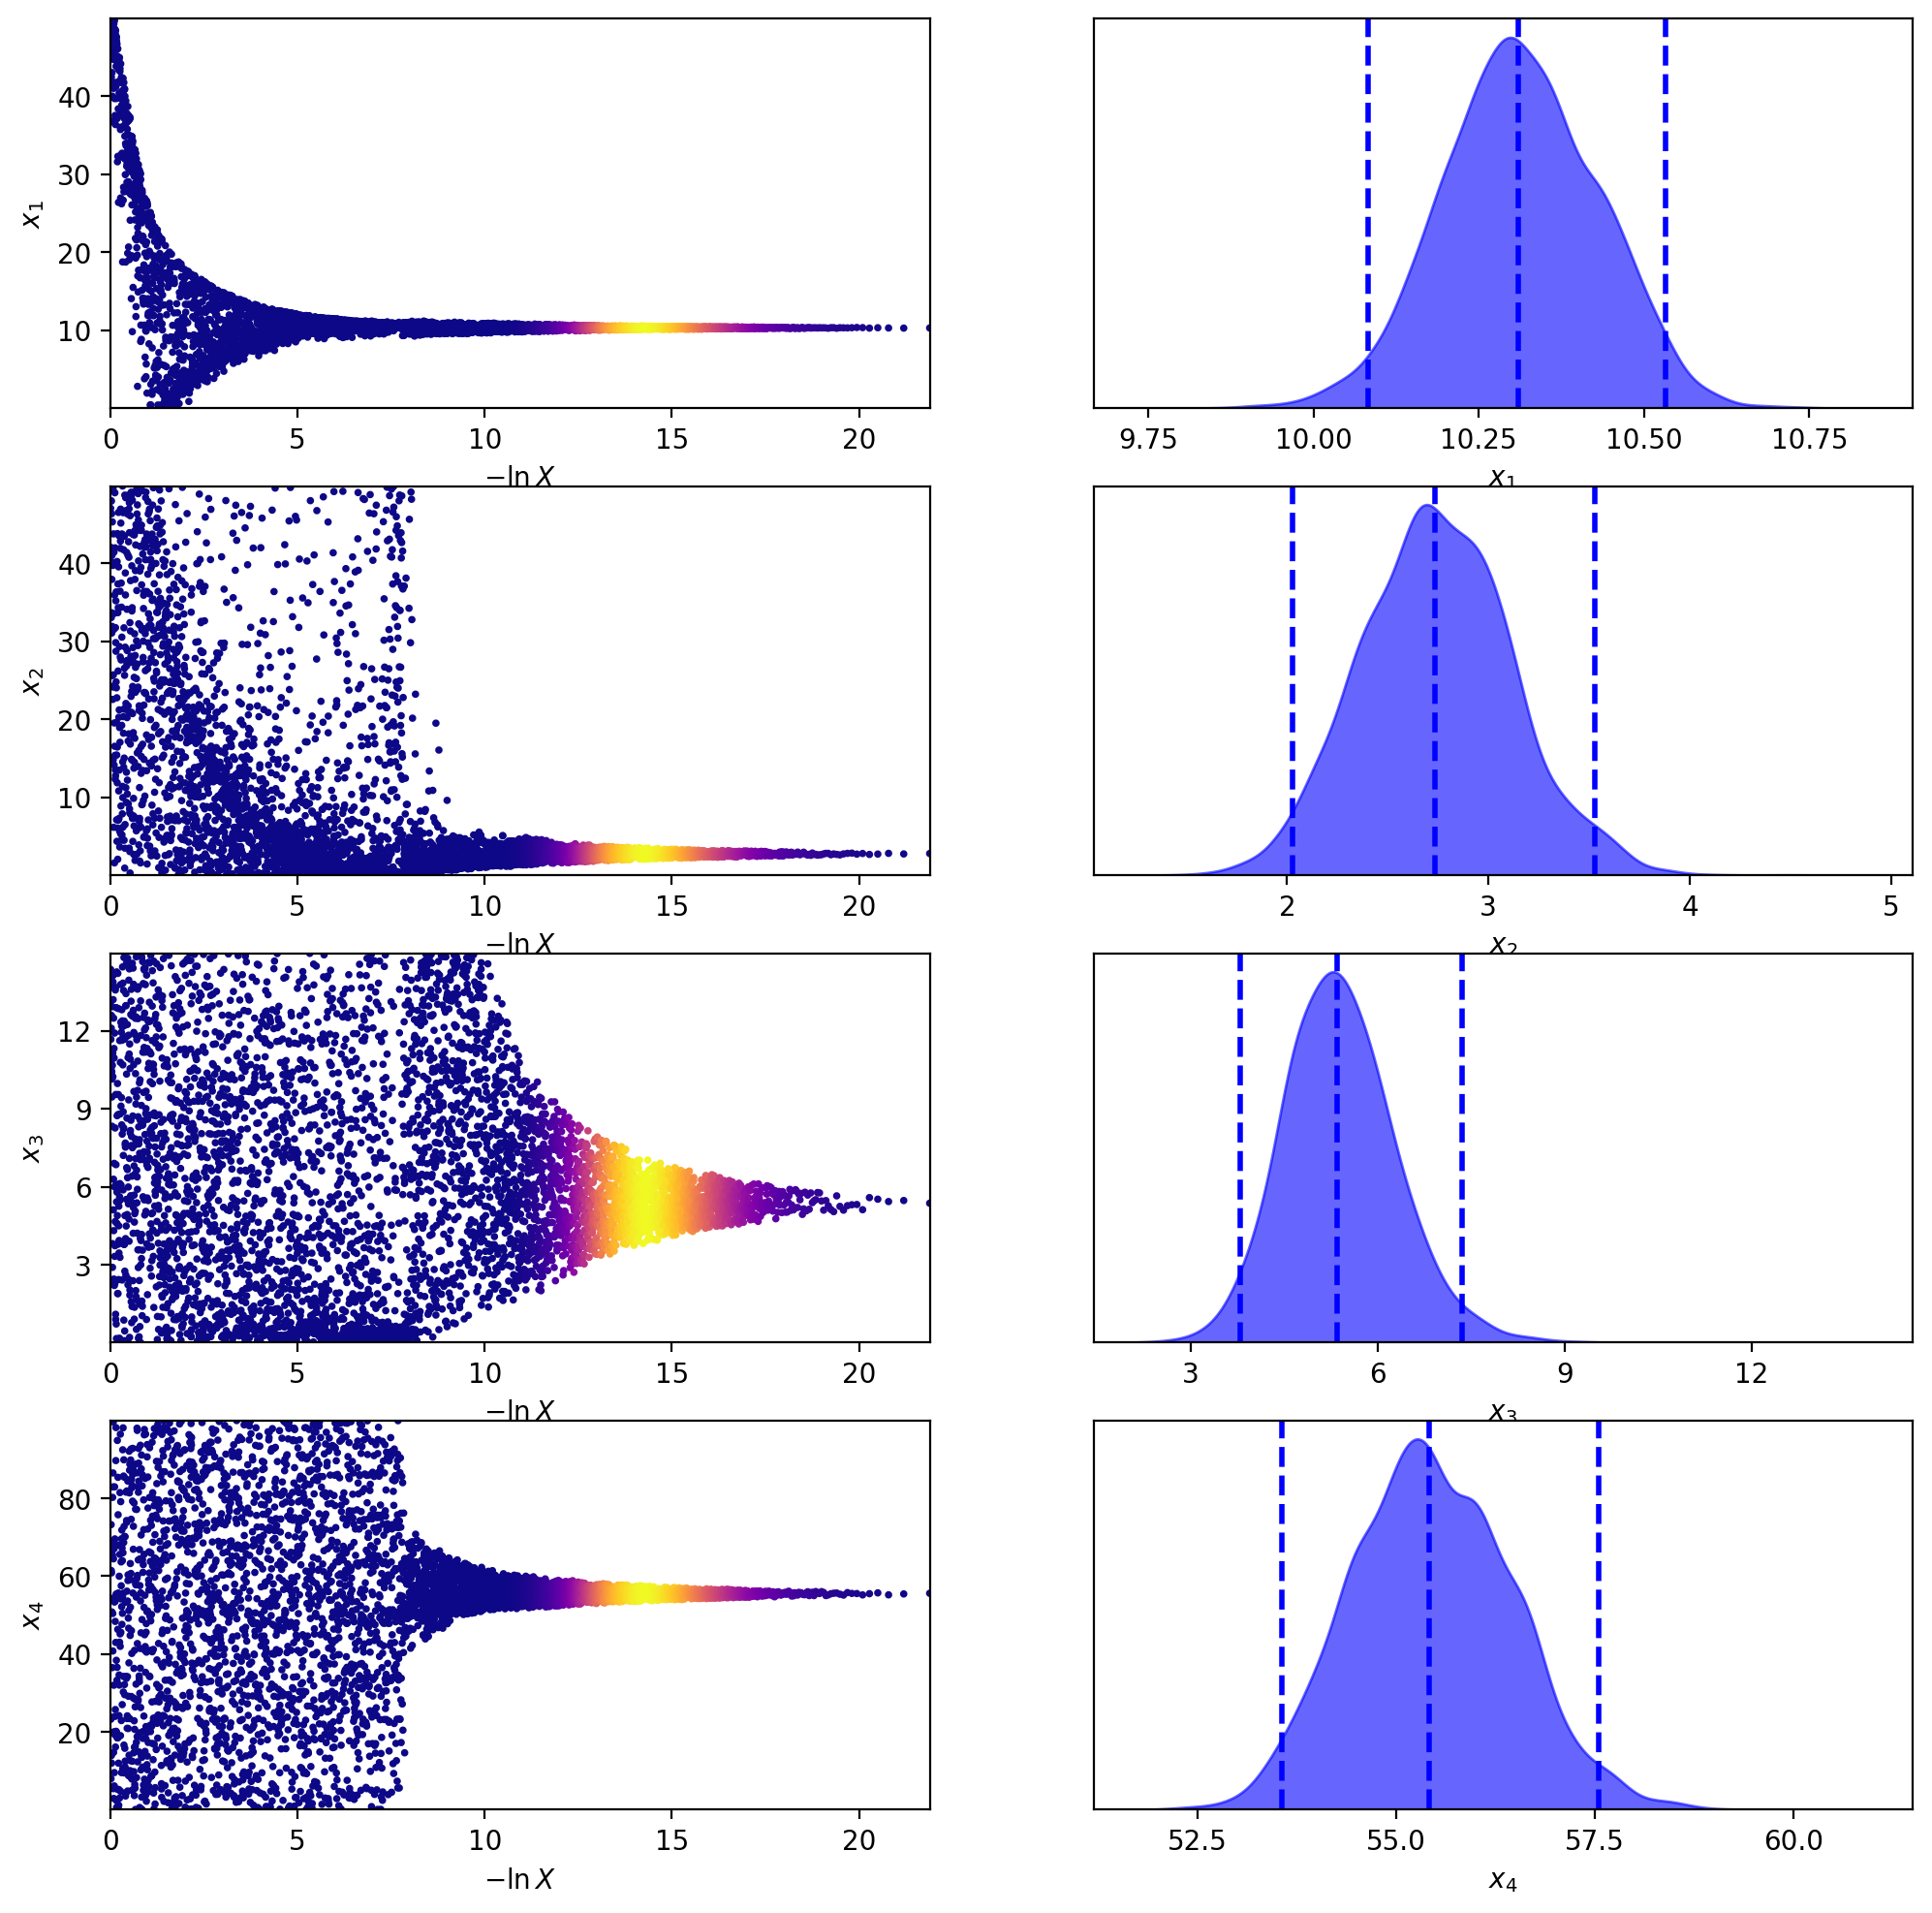

In [20]:
tfig, taxes = dyplot.traceplot(sresults_g)

In [22]:
# Extract sampling results.
samples = sresults_g.samples  # samples
weights = np.exp(sresults_g.logwt - sresults_g.logz[-1])  # normalized weights


evidence = sresults_g.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 5.387801644989922e-30
90% parameter credible regions are:
 [[10.16351983494323, 10.46840039969184], [2.2784035135051655, 3.2043001866626564], [4.339084051764863, 6.527631844970628], [54.18439837632327, 56.73608815262127]]

Mean and covariance of parameters are: [10.31242959  2.74226806  5.39594172 55.45213715]
[[ 0.01391779 -0.00942504 -0.03529802 -0.01984051]
 [-0.00942504  0.14044343 -0.14921263 -0.11818752]
 [-0.03529802 -0.14921263  0.79207725  0.27417569]
 [-0.01984051 -0.11818752  0.27417569  1.01651964]]


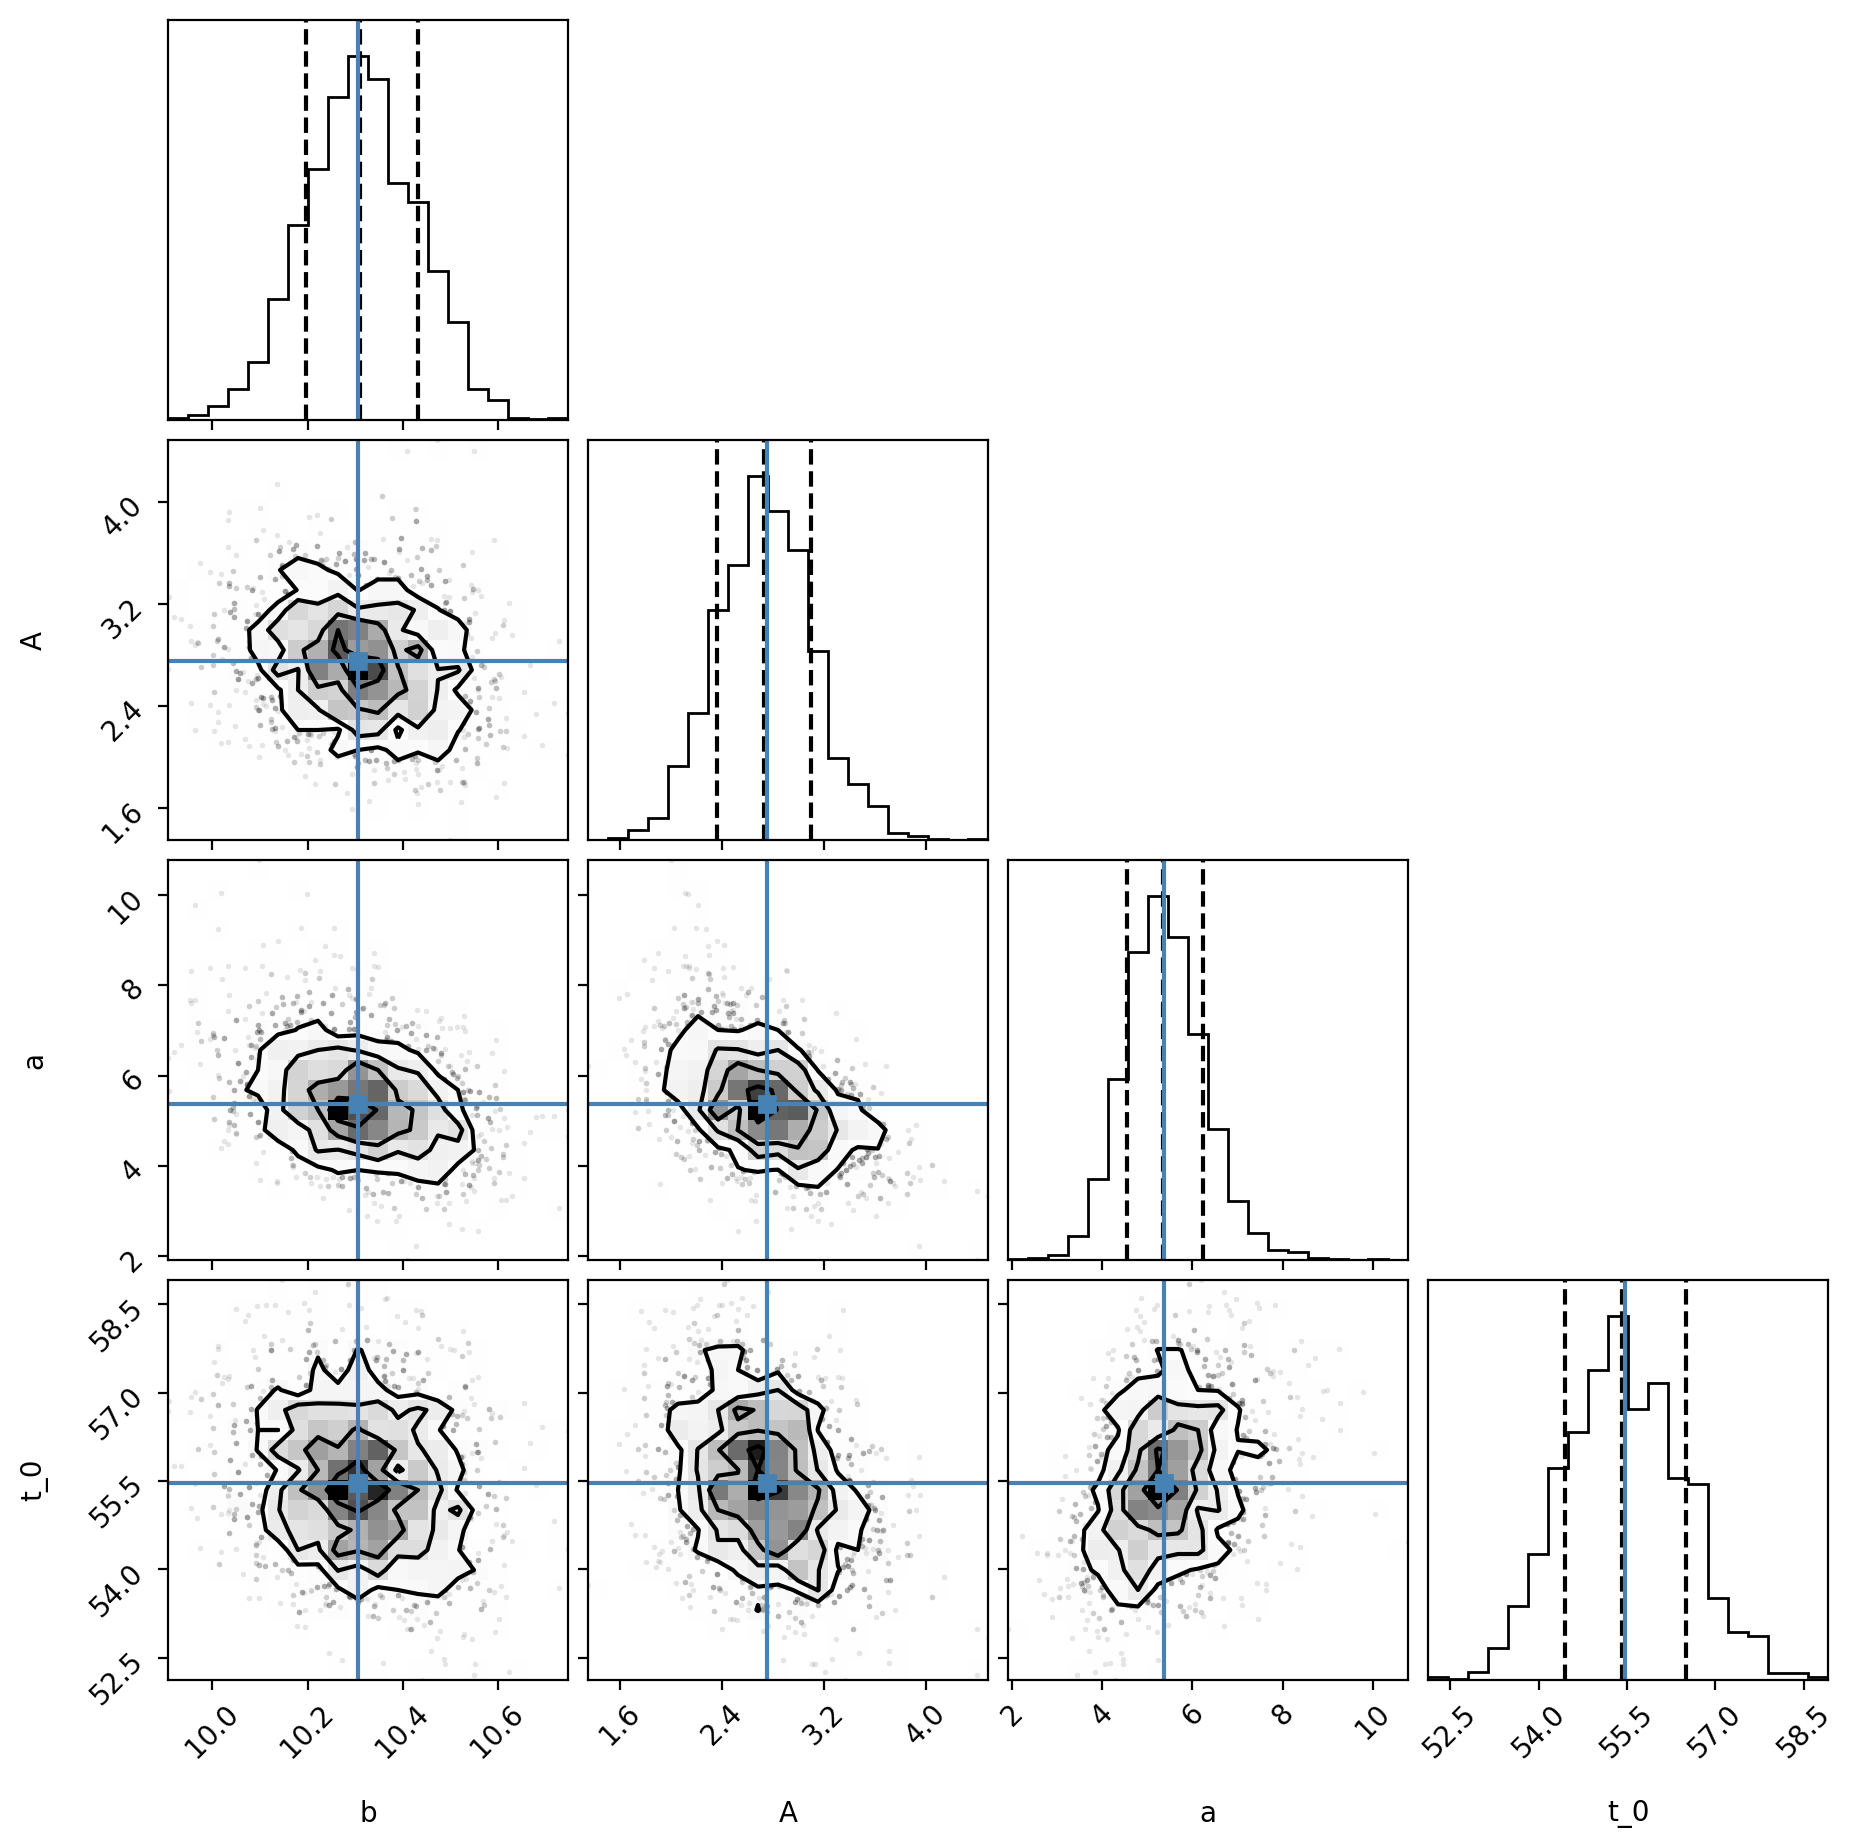

In [23]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ["b", "A", "a", "t_0"]
corner.corner(samples_equal, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [0.16, 0.5, 0.84]);

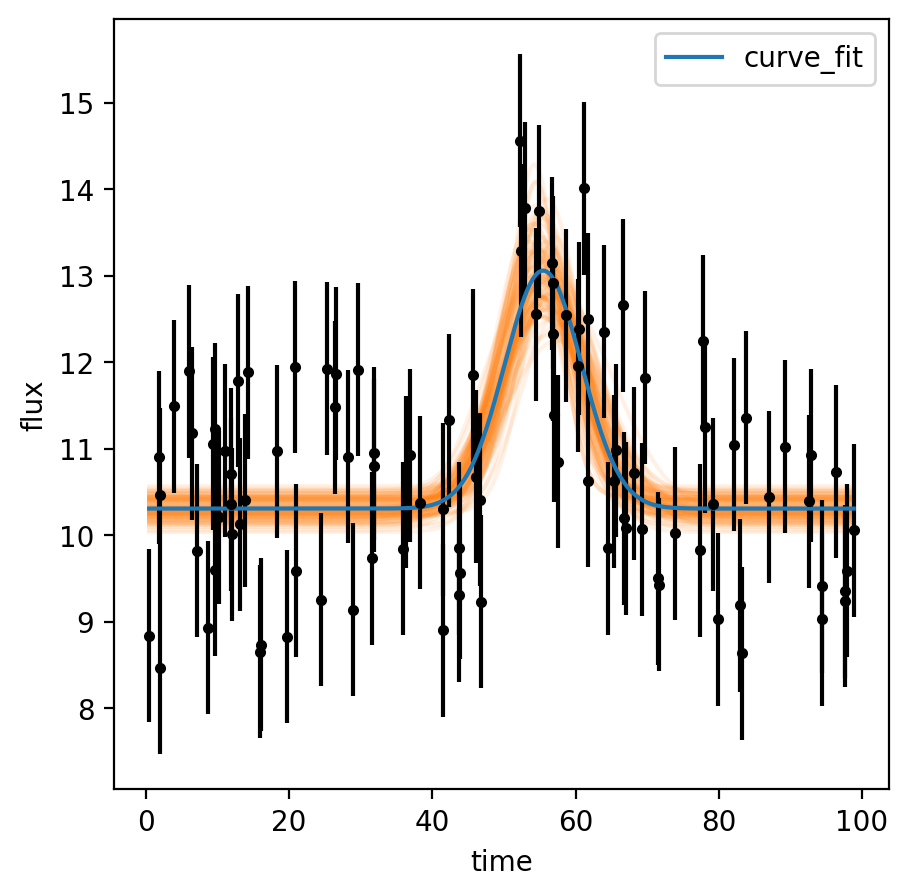

In [24]:
inds = np.random.randint(len(samples_equal), size=100)
x_fit = np.linspace(min(time), max(time), 1000)

for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_fit, gaussian_model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, gaussian_model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="curve_fit")
plt.legend()

plt.xlabel("time")
plt.ylabel("flux");

In [25]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
sresults_g.summary()

Summary
nlive: 300
niter: 4863
ncall: 57500
eff(%):  8.979
logz: -67.393 +/-  0.320


In [28]:
np.exp(sresults.logz[-1])/np.exp(sresults_g.logz[-1]) #Very strong evidence in favour of the Burst model

95.57701558781623